1. Load the data & divide the training & test & prepare for model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler  
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [2]:
train = pd.read_csv(r'C:\\Users\dongw\OneDrive\Documents\2. Programming\Springboard\DS\Lending Club Loan\data\train_df.csv')
test = pd.read_csv(r'C:\\Users\dongw\OneDrive\Documents\2. Programming\Springboard\DS\Lending Club Loan\data\test_df.csv')

In [3]:
print('train dataset is ' + str(train.shape))
print('test dataset is ' + str(test.shape))

train dataset is (1034178, 87)
test dataset is (258545, 87)


In [4]:
train.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'revol_bal', 'revol_util',
       'total_acc', 'total_rec_prncp', 'total_rec_int', 'tot_cur_bal',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'sub_grade_A2', 'sub_grade_A3',
       'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
       'sub_grade_B3', 'sub_grade_B4', 

In [5]:
#feature 'totalR_rec_prncp'Principal received to date, will be dropped before proceeding, because it was found dominant 
# for contributing default, one reason is that as long as the principle received to date is not met the loan repay, it is highly
# prone that the model believe there are very 'default' type.

train.drop(columns=['total_rec_prncp', 'total_rec_int'], inplace = True)
test.drop(columns=['total_rec_prncp', 'total_rec_int'], inplace = True)

In [6]:
#split X, y in training and testing sets

X_train = train.drop('Default', axis=1)
y_train = train['Default']
X_test = test.drop('Default', axis=1)
y_test = test['Default']

2. Downsampling the dataset and resample

In [7]:
#It is clear that default group has less cases, but we will check the ratio of the groups

default = train[train.Default == 1]
no_default = train[train.Default == 0]
ratio = default.shape[0]/no_default.shape[0]
ratio

0.26413874285071676

In [8]:
#downsample the training data, to balance class labels

#sampling_strategy = 1
under = RandomUnderSampler(random_state=42, replacement = True)
X_dn, y_dn = under.fit_resample(X_train, y_train)
print(X_dn.shape, X_train.shape)
y_dn = pd.DataFrame(y_dn, columns = ['Default'])
y_dn.Default.value_counts()


(432178, 84) (1034178, 84)


1    216089
0    216089
Name: Default, dtype: int64

In [9]:
#combine downsized X, y into one dataframe

new_train = pd.concat([X_dn, y_dn],axis=1)

In [11]:
#shuffle the data before creating the subsamples, with 0.1 fraction, after subsampling it is still chanlleging to run in local
#I decided to run with 1/10 sample after downsampling 

new_train = new_train.sample(frac = 0.1, random_state=42)

In [12]:
X_train = new_train.drop('Default', axis=1)
y_train = new_train['Default']

3. simple rf application

In [13]:
# randomforest model, 
from pprint import pprint

rf = RandomForestClassifier(random_state = 42)
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [14]:
from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer

start = timer()
rf.fit(X_train, y_train)
train_time = timer() - start

y_probs = rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_probs)

print('The baseline score on the test set is {:.4f}.' .format(auc))
print('The baseline training time is {:.4f} seconds' .format(train_time))

The baseline score on the test set is 0.6933.
The baseline training time is 0.8522 seconds


random sampling with 0.1 fraction drop the score from 0.71 to 0.6933.

In [15]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.68      0.76    204435
           1       0.33      0.60      0.43     54110

    accuracy                           0.66    258545
   macro avg       0.60      0.64      0.59    258545
weighted avg       0.75      0.66      0.69    258545



From the prediction, we were measuring ROC AUC (this is to describe the model predict probabilities) and F1, precision, recall metrics for the performance.

In [17]:
probs = rf.predict_proba(X_test)

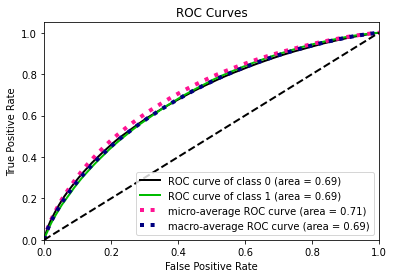

In [18]:
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, probs)
plt.show()

The base model of rf is not randomly predict the classes, and it is showing class separation capacity. However, precision of default if low, the percentage of true default that are correctly identified is not very ideal. Recall(0.69), means that the percentage of true default can be classified correctly, meaing after default being classfied, high chance that they are correct.

4. Hyperparameter of rf

In [22]:
#hyperparameter grid

#define class_weight
#class_weight = ['balanced', 'balanced_subsample', None]

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 6)]
#max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
#bootstrap = [True, False]

# Create the random grid
#param_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
  #             'max_depth': max_depth,
 #              'min_samples_split': min_samples_split,
 #              'min_samples_leaf': min_samples_leaf,
  #            'class_weight' : class_weight}
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
             'max_features': max_features,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf}

pprint(param_grid)

{'max_depth': [10, 30, 50, 70, 90, 110],
 'max_features': ['sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [23]:
import random

#Randomly sample parameters for rf

params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
params

{'n_estimators': 1600,
 'max_features': 'log2',
 'max_depth': 50,
 'min_samples_split': 2,
 'min_samples_leaf': 4}

{'n_estimators': 1600,
 'max_features': 'log2',
 'max_depth': 50,
 'min_samples_split': 2,
 'min_samples_leaf': 4} Use this random generated params for a run

In [24]:
rf2 = RandomForestClassifier(
    n_estimators = 1600,
    max_depth = 50,
    max_features = 'log2',
    min_samples_split = 2,
    min_samples_leaf = 4,
    n_jobs = -1,
    random_state = 0)

In [25]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=3, random_state=123, shuffle=True)
start = timer()
rf2_cv_score = cross_val_score(rf2, X_train, y_train, cv=cv, scoring='roc_auc')
rf2_time = timer() - start
rf2_time

7.725678000000016

In [26]:
rf2_auc = rf2_cv_score.mean()
print('The mean score of rf with random selected params on the training set is {:.4f}.' .format(rf2_auc))

The mean score of rf with random selected params on the training set is 0.7087.


In [27]:
start = timer()
rf2.fit(X_train, y_train)
rf2_training_time = timer() - start
rf2_training_time

2.612435699999992

The rf2 model score on the test set is 0.7054.


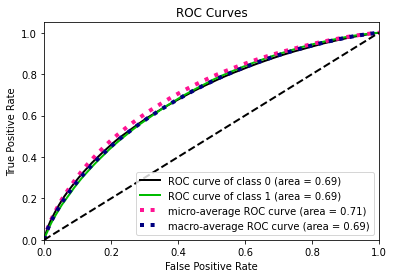

In [28]:
y_probs_2 = rf2.predict_proba(X_test)[:, 1]
auc_2 = roc_auc_score(y_test, y_probs_2)
print('The rf2 model score on the test set is {:.4f}.' .format(auc_2))

probs_2 = rf2.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, probs)
plt.show()

Compared to baseline model, 0.6933, 0.7054 has increased slightly. with params {'n_estimators': 1600, 'max_features': 'log2', 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 4}  Use this random generated params for a run

In [33]:
#perform random search of parameters
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
rf_random = RandomizedSearchCV(rf, param_distributions = param_grid, cv = cv, n_iter =100, random_state=42, n_jobs = -1)

In [34]:
start = timer()
rf_random.fit(X_train, y_train)
end=timer()
time = end-start
time

497.1977843000001

Some combinations of the hyperparameters prposed above are invalid. You can make the parameter search accept such failurs by setting error_score to np.nan. although there is no setting for np.nan. it was runnning ok. 

In [35]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70}

In [36]:
rf3 = RandomForestClassifier(
    n_estimators = 800,
    min_samples_split = 2,
    min_samples_leaf =1,
    max_depth=70,
    max_features='sqrt',
    n_jobs=-1,
    random_state=0)

In [37]:
start = timer()
modelOpt = rf3.fit(X_train, y_train)
end=timer()
time = end-start
time

1.8317696999999953

The modelOpt score on the test set is 0.7016.


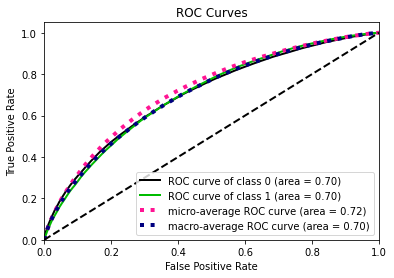

In [38]:
y_probs_3 = modelOpt.predict_proba(X_test)[:, 1]
auc_3 = roc_auc_score(y_test, y_probs_3)
print('The modelOpt score on the test set is {:.4f}.' .format(auc_3))

probs_3 = modelOpt.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, probs_3)
plt.show()

ROC score is not improved than previous random parameter, ROC curve areas are all improved.

5.Use model rf_2 on unscaled downsampled dataset 

In [39]:
train = pd.read_csv(r'C:\\Users\dongw\OneDrive\Documents\2. Programming\Springboard\DS\Lending Club Loan\data\train_df.csv')
test = pd.read_csv(r'C:\\Users\dongw\OneDrive\Documents\2. Programming\Springboard\DS\Lending Club Loan\data\test_df.csv')

In [40]:
train.drop(columns=['total_rec_prncp', 'total_rec_int'], inplace = True)
test.drop(columns=['total_rec_prncp', 'total_rec_int'], inplace = True)
X_train = train.drop('Default', axis=1)
y_train = train['Default']
X_test = test.drop('Default', axis=1)
y_test = test['Default']

In [41]:
#downsample the training data, to balance class labels

#sampling_strategy = 1
under = RandomUnderSampler(random_state=42, replacement = True)
X_dn, y_dn = under.fit_resample(X_train, y_train)
print(X_dn.shape, X_train.shape)
y_dn = pd.DataFrame(y_dn, columns = ['Default'])
y_dn.Default.value_counts()

(432178, 84) (1034178, 84)


In [45]:
rf2.fit(X_dn, y_dn.values.ravel())

RandomForestClassifier(max_depth=50, max_features='log2', min_samples_leaf=4,
                       n_estimators=1600, n_jobs=-1, random_state=0)

The rf2 model score on the test set is 0.7220.


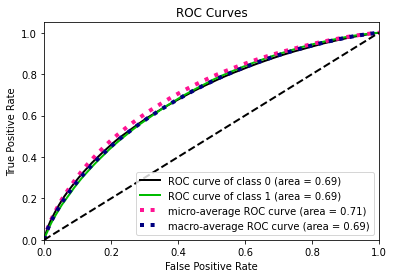

In [46]:
y_probs_2 = rf2.predict_proba(X_test)[:, 1]
auc_2 = roc_auc_score(y_test, y_probs_2)
print('The rf2 model score on the test set is {:.4f}.' .format(auc_2))

probs_2 = rf2.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, probs)
plt.show()

In [48]:
y_pred = rf2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.61      0.73    204435
           1       0.33      0.71      0.45     54110

    accuracy                           0.63    258545
   macro avg       0.61      0.66      0.59    258545
weighted avg       0.77      0.63      0.67    258545



We have downsampled the data and resample the data as an input to test randomforest model. Random params had better perfermance, although randomsearchCV proposed a 'combination' of best parameters. The selected good model then was applied to unscaled undersample data which have balanced classes.

We will look at the first 30 features and put them in descending order.

30


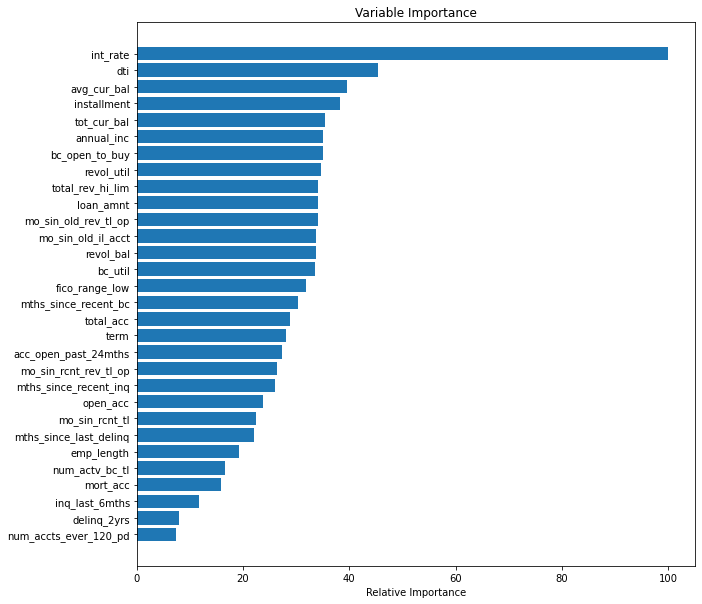

In [47]:
feature_importance = rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

int_rate showing a great contribution for RF model.